In [1]:
import numpy as np
import pandas as pd
from scipy.stats import circmean
from scipy.fftpack import fft, fftfreq
from scipy.signal import freqz, lfilter, iirnotch, butter, welch, csd, hilbert
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Task 1: Filters and cleaning noise

### Section A

#### Question 1

Voltage-Sensitive Dye Imaging (VSDI) is an optical imaging technique with high spatial and temporal resolution, that converts changes in membrane potential of cortical cells to measurable optical signals. Due to its small signals and considerable sensitivity to noise, VSDI requires a robust experimental setup. For example, Shoham et al, 1999, described a traditional design to study orientation maps in the visual cortex of cats. The cortex of the animal is accessed via a cranial window, illuminated by an epi-illumination stage and imaged by a fast camera through a macroscope optical system. The main computer controls the camera and preliminarily stores and analyses incoming data. A second computer separately generates the visual stimulus that is shown to the animal on a monitor. The computing system performs several tasks processed by different components:

-	A subsystem to monitor heartbeat
-	A microcontroller box to synchronise data acquisition with heartbeat and respiration 
-	A sequence generator to time the visual stimulus
-	A respirator
-	A subsystem made of a PC, a generator box and a monitor to generate the visual stimulus
-	Controllers to adjust illumination and eye shutter
-	Controller box and camera to record cortical activity

#### Question 2

VSDI involves three types of noise. The first two types are caused by unspecific optical signal either from non-neuronal structures that bind to the dye, such as glia cells and the extracellular matrix, or from synaptic potentials at the dendrites below the threshold for an action potential. The third and major type is the wavelength-dependent and blood-related artifact due to heartbeat, as the excitation wavelength of common dyes lies close to the peak absorption of hemoglobin.

#### Question 3

The basic VSDI analysis represents a standard analytical pipeline for optical signals obtained from cortical activity (Ayzenshtat et al, 2010). It is used to improve the quality of the data by increasing its signal-to-noise ratio and removing potential artifacts, primarily heartbeat noise. The basic VSDI analysis involves the following steps:

0. Stratification by stimulus type and pre-filtering trials. Signals originated from different stimulus types are grouped separately and trials with poor eye fixation are filtered.

1. Defining the region of interest. Pixels with sufficient illumination levels, such as at least 15% of the maximal value, are selected to form a circular region of interest that is further analysed.

2. Normalisation by background fluorescence. Because illumination – and thus baseline response – varies with pixel position, optical response is normalised by division with pixel-wise fluorescence value prior to stimulation.

3. Substraction of average blank response. To remove the main artifact in VSDI data – heartbeat pulsation – sessions with only fixation and no stimulation are performed in synchronisation with the animal’s heartbeat, and their mean response over time is determined. This is then subtracted from each trial to obtain an obtical signal free of the heartbeat artifact.

4. Subtraction of linear trend. When processed sessions still exhibit a gradual decline over time, it is possible to linearise them by removing such linear trend.

The resulting optical signals present low bias and can be used to generate neural activation maps of the cortex for individual stimulus types.

#### Question 4

Subtraction of the average blank response is used to reduce the artifact in the optical signal due to hearbeat pulsation. If we were to apply a filter to remove the frequency of heartbeat pulsation, the relevant signal present at such frequency, but produced by the stimulus of interest, would be cancelled as well. Instead, subtraction of the baseline response without stimulation can help preserve the relevant component of the signal and can be easily adapted to individuals with differences in hearbeat rate.

### Section B

The data is imported and splitted into the blank session and the stimulus session.

In [2]:
# Import data
var4students = np.load("data/var4students.npy", allow_pickle=True)
blank = var4students.item().get("blank")
stimulus = var4students.item().get("stimulus")

The experimental parameters are defined and the time sequence is generated.

In [11]:
# Set experimental parameters
Fs = 100
T, N = blank.shape

# Generate time sequence
time = 1000 * np.arange(T) / Fs

Two functions are defined to compute or plot the mean and SEM for a set of trials, respectively.

In [4]:
# Define function to compute mean and SEM of trial
def find_stats(arr, keepdims=False):

    arr_mean = np.mean(arr, axis=1, keepdims=keepdims)
    arr_sem = np.std(arr, axis=1) / np.sqrt(arr.shape[1] - 1)

    return arr_mean, arr_sem

# Define function to plot mean response and uncertainty of trial
def plot_stats(time, arr_mean, arr_sem, label="", ax=None):

    if ax == None:
        plt.plot(time, arr_mean, label=label)
        plt.fill_between(time, arr_mean - arr_sem, arr_mean + arr_sem, alpha=0.5)
    else:
        ax.plot(time, arr_mean, label=label)
        ax.fill_between(time, arr_mean - arr_sem, arr_mean + arr_sem, alpha=0.5)

The average responses for blank and stimulus conditions are visualised below.

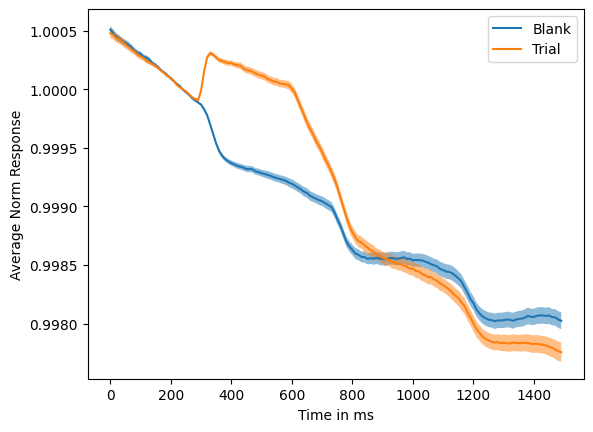

In [5]:
# Compute stats for blank
blank_mean, blank_sem = find_stats(blank)
# Compute stats for stimulus
stimulus_mean, stimulus_sem = find_stats(stimulus)

# Visualise average response for blank
plot_stats(time, blank_mean, blank_sem, label="Blank")
# Visualise average response for stimulus
plot_stats(time, stimulus_mean, stimulus_sem, label="Trial")

plt.xlabel("Time in ms") 
plt.ylabel("Average Norm Response")
plt.legend(loc="upper right")

The average response exhibits oscillations between 2 and 2.5 Hz. In addition, the signal gradually declines about every 200 ms (5 Hz). Notably, such frequency range is typically associated with heartbeat pulsation.

### Section C

As a first option, the heartbeat artifact can be cleaned with a filter. First, the power spectrum of each stimulated trial is obtained.

In [6]:
# Find frequencies
freq = fftfreq(T, d=1 / Fs)
half_length = freq.size // 2

# Perform FFT on stimulus
stimulus_power = fft(stimulus - np.mean(stimulus, axis=0), axis=0)

The average spectrum across stimulated trials is visualised below.

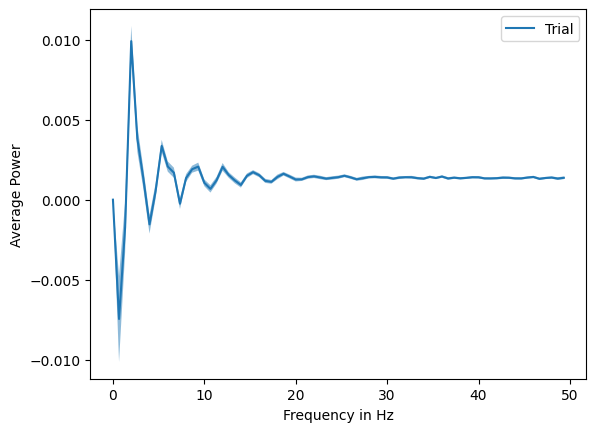

In [7]:
# Compute stats for stimulus
stimulus_power_mean, stimulus_power_sem = find_stats(stimulus_power)

# Visualise average spectrum for stimulus
plot_stats(freq[:half_length], stimulus_power_mean[:half_length], stimulus_power_sem[:half_length], label="Trial")

plt.xlabel("Frequency in Hz") 
plt.ylabel("Average Power")
plt.legend(loc="upper right")

A peak appears in the average spectrum between frequencies of 2 and 5 Hz. To clean the heartbeat artifact at such frequencies, we apply an IIR Notch filter to each individual trial, which selects the maximum frequency between 2 and 5 Hz and removes it with a bandwidth of 0.1 Hz. For the purpose of demonstration, such filter is designed below for a frequency of 2.5 Hz.

In [8]:
# Select example frequency to filter
f0 = 2.5
# Set bandwidth
bandwidth = 0.1

# Design IIR Notch filter
b, a = iirnotch(f0, f0 / bandwidth, Fs)

# Create impulse array
impulse = np.zeros(T)
impulse[0] = 1

# Apply filter to impulse array
impulse_response = lfilter(b, a, impulse)

# Compute the frequency response
freq_range, freq_response = freqz(b, a, fs=Fs)

The impulse and frequency responses of the example filter are visualised below.

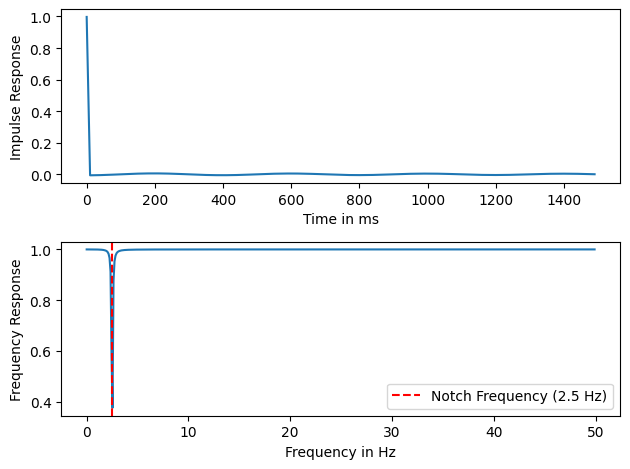

In [9]:
fig, axes = plt.subplots(2)

# Visualise the impulse response
axes[0].plot(time, impulse_response)

axes[0].set_xlabel("Time in ms")
axes[0].set_ylabel("Impulse Response")

# Visualise the frequency response
axes[1].plot(freq_range, freq_response)
axes[1].axvline(f0, color="r", linestyle="--", label=f"Notch Frequency ({f0} Hz)")

axes[1].set_xlabel("Frequency in Hz")
axes[1].set_ylabel("Frequency Response")
axes[1].legend()

plt.tight_layout()

The upper plot shows the impulse response of the filter. As expected from an IIR filter, a fraction of the output is maintained even after a long time in the impulse response. The lower plot depicts the frequency response of the filter. As expected from a Notch filter, a single frequency is removed (in this case, 2.5 Hz with a bandwidth of 0.1 Hz), whereas the rest of the spectrum is not affected. Such design is ideal to remove the peak frequency at which the heartbeat rate occurs. However, it will also remove the relevant component of the signal at the same frequency.

Next, a function is defined to apply the IIR Notch filter to each trial and remove the peak frequency within a range of choice, which in the case of heartbeat filtering lies between 2 and 5 Hz.

In [14]:
# Define function to apply IIR Notch filter to maximum frequency within a range for each trial
def apply_filter(sig, freq, power, Fs, freq_range=[2, 5], bandwidth=0.1):

    # Find indices of frequencies within the range
    range_idx = np.where((freq >= freq_range[0]) & (freq <= freq_range[1]), True, False)
    # Find index of max power within the range for each trial
    max_idx = np.argmax(power[range_idx, :], axis=0)

    # Retrieve heartbeat frequency for each trial
    heartbeat = freq[range_idx][max_idx]
    # Prepare empty array to collect filter signal
    filtered_sig = np.zeros_like(sig)

    # Iterate over trials
    for i in range(heartbeat.size):

        # Design filter to remove hearbeat frequency of trial
        b, a = iirnotch(heartbeat[i], heartbeat[i] / bandwidth, Fs)
        # Apply filter to trial
        filtered_trial = lfilter(b, a, sig[:, i])
        # Store filtered trial in output array
        filtered_sig[:, i] = filtered_trial

    return filtered_sig

The filter is applied to the stimulated trials.

In [15]:
# Apply filter to each trial of stimulus
filtered_stimulus = apply_filter(stimulus, freq, stimulus_power, Fs)

The filtered signal is visualised and compared with the raw signal.

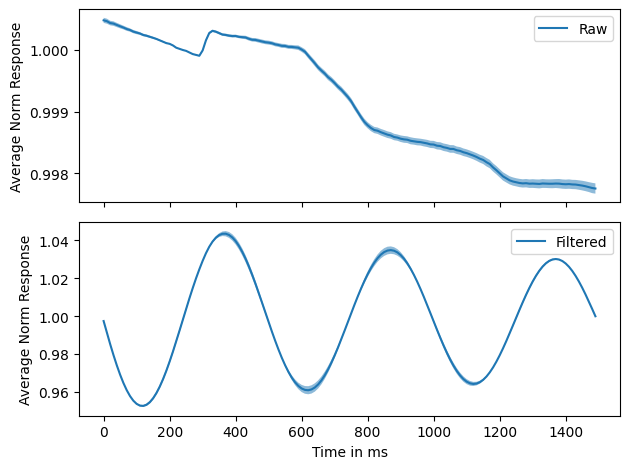

In [64]:
fig, axes = plt.subplots(2, sharex=True)

# Visualise average response for stimulus
plot_stats(time, stimulus_mean, stimulus_sem, ax=axes[0], label="Raw")
# Visualise average response for filtered stimulus
plot_stats(time, filtered_stimulus_mean, filtered_stimulus_sem, ax=axes[1], label="Filtered")

axes[1].set_xlabel("Time in ms")
axes[0].set_ylabel("Average Norm Response")
axes[1].set_ylabel("Average Norm Response")

axes[0].legend(loc="upper right")
axes[1].legend(loc="upper right")

plt.tight_layout()

The filtered signal approaches a negative sine function with a frequency of about 2 Hz and some degree of damping. Compared to the raw signal, the filtered signal does not decline over time. The response to the stimulus might be encoded in the slightly higher wave found with the peak around 350 ms. However, it seems that this filtering approach failed to remove the heartbeat artifact, which is likely the reason for the almost pure sine wave. It is possible that the heartbeat frequency was removed from all but one trial (perhaps the single trial where the maximum frequency was 2.7 Hz and not 2 Hz), which results in a strong hearbeat pulsation that resembles a sine wave.

### Section D

The second approach to remove the heartbeat artifact involves subtracting the average blank response from each response with stimulation and then averaging the latter. Initially, the outliers most different from the mean trend are identified from the blank sessions and removed. The most evident outliers are compared to the mean blank response below.

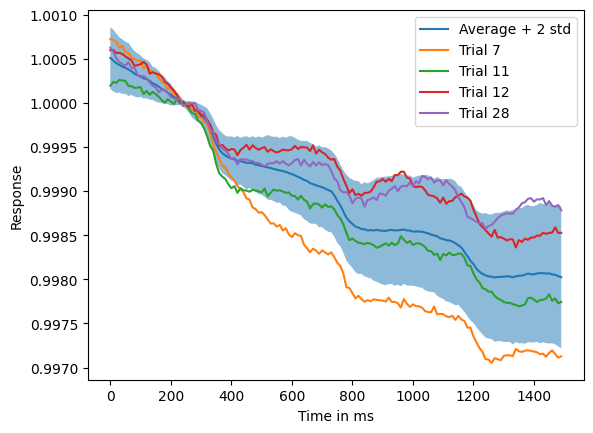

In [17]:
# Find standard deviation of blank
blank_std = np.std(blank, axis=1)
# Visually select greatest outlier blank sessions
outliers = [7, 11, 12, 28]

# Visualise mean blank response and 2 standard deviations
plot_stats(time, blank_mean, 2 * blank_std, label='Average + 2 std')

# Visualise 4 most evident outliers
for i in outliers:
    plt.plot(time, blank[:, i], label=f"Trial {i}")

plt.xlabel("Time in ms")
plt.ylabel("Response")
plt.legend()

To stimulated trials are normalised by the average response of the tidy blank sessions. Then, the average response for the trial is also calculated.

In [18]:
# Remove outliers from blank
tidy_blank = np.delete(blank, outliers, axis=1)

# Find mean and sem of tidy blank
tidy_blank_mean, tidy_blank_sem = find_stats(tidy_blank, keepdims=True)

# Normalise stimulated trials with mean response of normalised blank
norm_stimulus = stimulus / tidy_blank_mean

# Find mean and sem of normalised stimulated trials
norm_stimulus_mean, norm_stimulus_sem = find_stats(norm_stimulus)

The normalised signal is visualised and compared to the raw signal below.

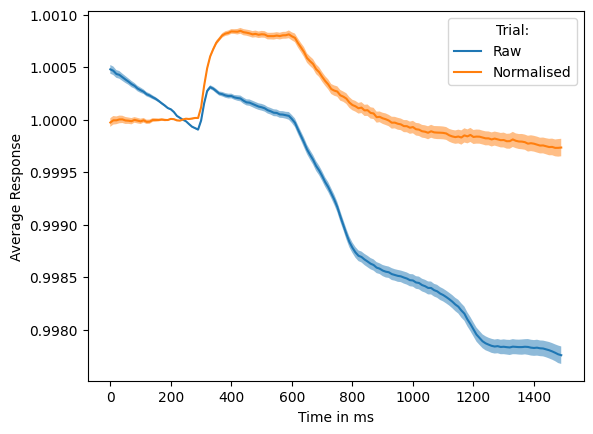

In [19]:
# Visualise mean and sem of raw stimulated trials
plot_stats(time, stimulus_mean, stimulus_sem, label="Raw")
# Visualise mean and sem of normalised stimulated trials
plot_stats(time, norm_stimulus_mean, norm_stimulus_sem, label="Normalised")

plt.xlabel("Time in ms")
plt.ylabel("Average Response")
plt.legend(title="Trial:", loc="upper right")

The normalisation approach managed to remove the declining trend from the signal, while also preserving the shape of the response to stimulus.

### Section E

The two approaches (filtering and normalisation) are compared both in the time and frequency domains. First, the filtered and normalised signals are compared in terms of response amplitude.

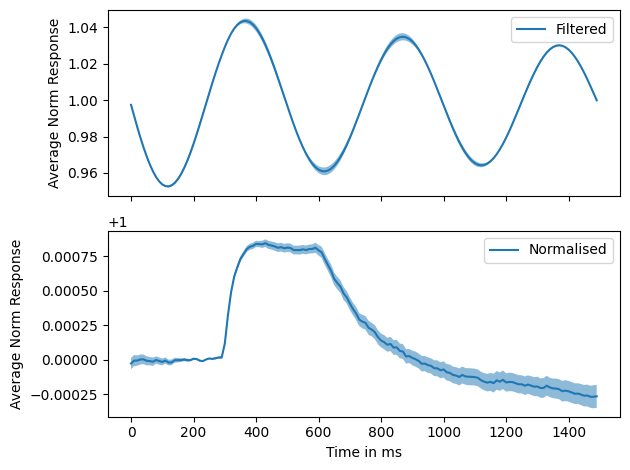

In [59]:
fig, axes = plt.subplots(2, sharex=True)

# Visualise average response for filtered stimulus
plot_stats(time, filtered_stimulus_mean, filtered_stimulus_sem, ax=axes[0], label="Filtered")
# Visualise average response for stimulus
plot_stats(time, norm_stimulus_mean, norm_stimulus_sem, ax=axes[1], label="Normalised")

axes[1].set_xlabel("Time in ms")
axes[0].set_ylabel("Average Norm Response")
axes[1].set_ylabel("Average Norm Response")

axes[0].legend(loc="upper right")
axes[1].legend(loc="upper right")

plt.tight_layout()

Clearly, the normalisation approach outperforms the filtering approach in preserving the shape of the response to stimulus, which is nearly lost with the filtering approach for reasons explained in detail in section C. Next the spectra for the two versions of the signal are determined via DFT and compared with one another.

In [20]:
# Perform FFT on filtered stimulated trials
filtered_stimulus_power = fft(filtered_stimulus - np.mean(filtered_stimulus, axis=0), axis=0)
# Perform FFT on normalised stimulated trials
norm_stimulus_power = fft(norm_stimulus - np.mean(norm_stimulus, axis=0), axis=0)

# Find mean and sem of spectrum for filtered stimulated trials
filtered_stimulus_power_mean, filtered_stimulus_power_sem = find_stats(filtered_stimulus_power)
# Find mean and sem of spectrum for normalised stimulated trials
norm_stimulus_power_mean, norm_stimulus_power_sem = find_stats(norm_stimulus_power)

The spectra of the filtered and normalised signal are visualised and compared below.

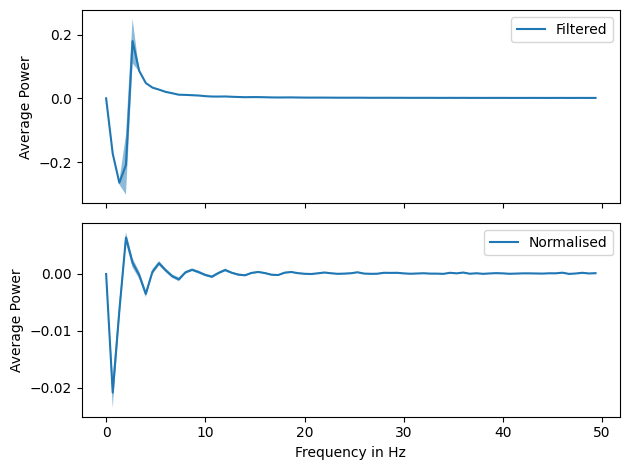

In [21]:
fig, axes = plt.subplots(2, sharex=True)

# Visualise average response for filtered stimulus
plot_stats(
    freq[:half_length], filtered_stimulus_power_mean[:half_length], filtered_stimulus_power_sem[:half_length],
    ax=axes[0], label="Filtered"
)
# Visualise average response for stimulus
plot_stats(
    freq[:half_length], norm_stimulus_power_mean[:half_length], norm_stimulus_power_sem[:half_length],
    ax=axes[1], label="Normalised"
)

axes[1].set_xlabel("Frequency in Hz")
axes[0].set_ylabel("Average Power")
axes[1].set_ylabel("Average Power")

axes[0].legend(loc="upper right")
axes[1].legend(loc="upper right")

plt.tight_layout()

Both spectra exhibit a peak at 2 Hz. For the filtering approach, this suggests that it did not succesfully remove the heartbeat pulsation from one of the trials. Also, no other frequencies are left in the spectrum. For the normalisation approach, the peak at 2 Hz and the additional oscillations until frequencies around 15 Hz suggest that frequencies relevant for the response to stimulation are preserved, while most of the heartbeat component was likely removed by subtracting the average blank response. Taken altogether, we recommend Prof. Agnon to use the normalisation approach because it appears more robust and less sensible to variations in hearbeat frequency across trials.

## Task 2: Fourier Transform

### Section A

A signal $x(t)$ is given for which the Fourier transform $X(\omega)$ must be calculated:

$x(t) = cos(2\pi \alpha t)\cdot cos(2\pi \beta t)$

The trigonometric property of multiplication holds such that:

$cos\alpha\cdot cos\beta = \frac{1}{2}[cos(\alpha - \beta) + cos(\alpha + \beta)]$

It can be applied to $x(t)$ to obtain the following expression:

$x(t) = \frac{1}{2}[cos2\pi (\alpha - \beta)t + cos2\pi (\alpha + \beta)t]$

Moreover, the two elements differ only in the sign between $\alpha$ and $\beta$, which can be substituted with a placeholder:

$\omega_1 = 2 \pi (\alpha - \beta)$ and $\omega_2 = 2 \pi (\alpha + \beta)$

The expression is thus reduced to the following:

$x(t) = \frac{1}{2}[cos\omega_1 t + cos\omega_2 t]$

In addition, it is possible to express the cosine in terms of complex numbers:

$cos(\omega_0 t) = \frac{1}{2}(e^{i \omega_0 t} + e^{-i \omega_0 t})$

The two cosines are substituted with such complex term:

$x(t) = \frac{1}{4}(e^{i \omega_1 t} + e^{-i \omega_1 t} + e^{i \omega_2 t} + e^{-i \omega_2 t})$

Now we are ready to apply the Fourier transform $X(\omega)$ of $x(t)$, which is normally defined as:

$X(\omega) = \frac{1}{2 \pi}\int_{-\infty}^{+\infty}x(t)\cdot e^{-i\omega t}dt$

However, we will refer to such operation as $F(x(t))$ and exploit the fact that the Fourier transform of a complex number equals the following Dirac delta function:

$F(e^{\pm i\omega_0 t}) = \delta(\omega \mp \omega_0)$

Note that the exponent should contain the extra term $2 \pi \omega$, wich was skipped because $\omega_1$ and $\omega_2$ as we defined them already contain the missing elements.

Initially, $X(\omega)$ appears as the Fourier transform of four complex numbers:

$X(\omega) = \frac{1}{4} F(e^{i \omega_1 t} + e^{-i \omega_1 t} + e^{i \omega_2 t} + e^{-i \omega_2 t})$

For the addition rule of integrals, the Fourier transform of the sum is equivalent to the sum of the Fourier transforms:

$X(\omega) = \frac{1}{4}[F(e^{i \omega_1 t}) + F(e^{-i \omega_1 t}) + F(e^{i \omega_2 t}) + F(e^{-i \omega_2 t})]$

Now, the four elements can be solved with the Fourier transform of a complex number, the Dirac function:

$X(\omega) = \frac{1}{4}[\delta(\omega - \omega_1) + \delta(\omega + \omega_1) + \delta(\omega - \omega_2) + \delta(\omega + \omega_2)]$

Finally, $\alpha$ and $\beta$ are substituted back to obtain the answer:

$X(\omega) = \frac{1}{4}[\delta(\omega - \alpha + \beta) + \delta(\omega + \alpha - \beta) + \delta(\omega - \alpha - \beta) + \delta(\omega + \alpha + \beta)]$

We observe that the Fourier transform of a multiplication between two cosine functions correspond to the sum of four Dirac delta functions of different terms. Importantly, the result may vary based on the the type of normalisation (here $\frac{1}{2 \pi}$).

### Section B

The two parameters $\alpha$ and $\beta$ are now given:

$\alpha = 10$ and $\beta = 110$

The two parameters can be plugged in the equation of $x(t)$:

$x(t) = cos(2\pi 10 t)\cdot cos(2\pi 110 t)$

The trigonometric property of multiplication is applied as before:

$x(t) = \frac{1}{2}[cos2\pi (-100)t + cos2\pi (120)t]$

The cosine function is characterised by the property of symmetry such that:

$cos(-x) = cos(x)$

Thus, the negative angle can be replaced with its positive counterpart:

$x(t) = \frac{1}{2}[cos2\pi (100)t + cos2\pi (120)t]$

The Nyquist frequency of a signal is defined as its maximal frequency:

$f_{max} = \frac{f_s}{2} = 120 s^{-1}$

To prevent aliasing, the sampling rate must be at least twice as great as the Nyquist frequency:

$\Rightarrow f_s \ge 2f_{max} = 240 s^{-1}$

In conclusion, the signal must be sampled at a frequency of at least 240 Hz to prevent aliasing.

### Section C

The signal is sampled at two frequencies (160 and 250 Hz) and results are compared.

In [67]:
# Set sampling rates
Fs1, Fs2 = 160, 250
# Set experiment length
T = 2

# Collect sample times
t1 = np.linspace(0, T, T * Fs1)
t2 = np.linspace(0, T, T * Fs2)

The signal is defined as the sum between two cosine functions, sampled at times `t1` and `t2`, respectively.

In [68]:
# Set signal parameters
a, b = 10, 110

y1 = np.cos(2 * np.pi * a * t1) * np.cos(2 * np.pi * b * t1)
y2 = np.cos(2 * np.pi * a * t2) * np.cos(2 * np.pi * b * t2)

The amplitudes for the two versions of the signal are visualised below for a duration of 2 seconds.

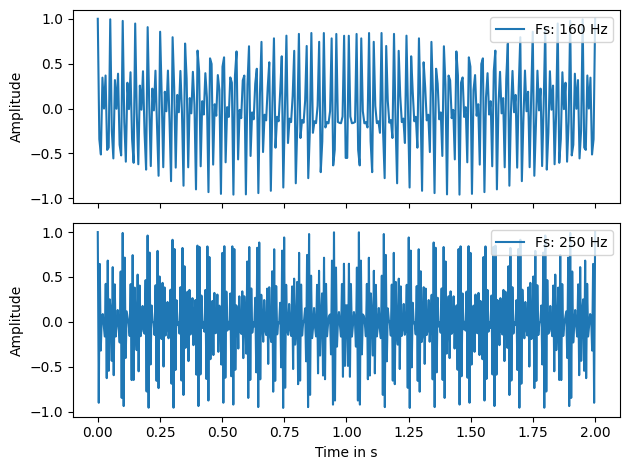

In [76]:
fig, axes = plt.subplots(2, sharex=True)

# Visualise signal at first sampling rate
axes[0].plot(t1, y1, label=f"Fs: {Fs1} Hz")
# Visualise signal at second sampling rate
axes[1].plot(t2, y2, label=f"Fs: {Fs2} Hz")

axes[0].set_ylabel("Amplitude")
axes[1].set_ylabel("Amplitude")
axes[1].set_xlabel("Time in s")

axes[0].legend(loc="upper right")
axes[1].legend(loc="upper right")

plt.tight_layout()

Clearly, the signal is subject to aliasing when sampled at 160 Hz, as its Nyquist frequency equals 120 Hz. Instead, the signal is clean from aliasing when sampled at 250 Hz, as such sampling rate is more than twice as great as the Nyquist frequency.

Next, the spectra of the two versions of the signal are determined by DFT.

In [77]:
# Collect frequencies at first sampling rate
freq1 = fftfreq(T * Fs1, d=1 / Fs1)
# Collect frequencies at second sampling rate
freq2 = fftfreq(T * Fs2, d=1 / Fs2)

# Perform FFT
Y1 = fft(y1)
Y2 = fft(y2)

The spectra are visualised and compared in the figure below.

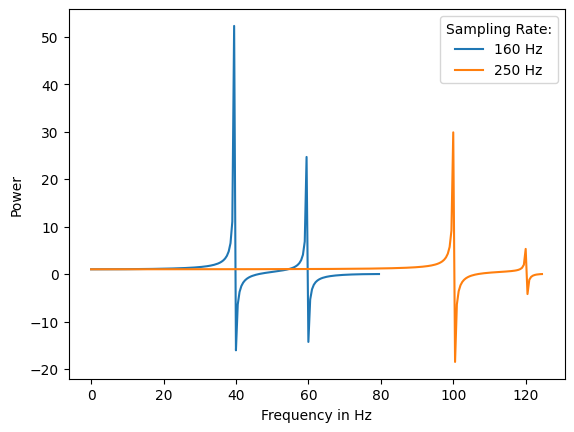

In [75]:
# Visualise positive spectrum for the two sampling rates
plt.plot(freq1[:T * Fs1 // 2], Y1[:T * Fs1 // 2], label=f"{Fs1} Hz")
plt.plot(freq2[:T * Fs2 // 2], Y2[:T * Fs2 // 2], label=f"{Fs2} Hz")

plt.xlabel("Frequency in Hz")
plt.ylabel("Power")
plt.legend(title="Sampling Rate:")

The signal sampled at 250 Hz correctly exhibits peaks at the original frequencies (100 and 120 Hz), whereas for the signal sampled at 160 Hz the peaks shifted to the left by 60 Hz, or half of the sampling rate, due to aliasing. Another effect of aliasing is the increase in the power at those two frequencies due to the additional artificial frequencies. Using an even higher sampling rate can further improve the spectrum and return a better estimate for the powers of the original frequencies.

## Task 3: Filters

### Section A

The signal and the filters are imported and stored in two separate objects.

In [29]:
# Import data
filters = np.load("data/filters.npy", allow_pickle=True)
filtVec = filters.item().get("filtVec")
dataVec = filters.item().get("dataVec").flatten()

The two rows of `filtVec` represent the coefficients for a filter defined as follows:

$y(n) = \sum_{k = 1}^{50} filtVec(i, k)\cdot x(n - k + 1)$

The function below can be used to apply the filter with either array of coefficients to a signal of choice.

In [30]:
# Define function to apply filters to signal
def apply_filter(x, f):

    # Prepare zero array to collect output
    y = np.zeros((f.shape[0], x.size))

    # Iterate over the input
    for n in range(x.size):
        # Iterate over a range of 50
        for k in range(filtVec.shape[1]):
            y[:, n] += f[:, k] * x[n - k]

    return y

The filter is applied to an impulse array to obtain its impulse response.

In [31]:
# Generate impulse array
impulse = np.zeros(filtVec.shape[1])
impulse[0] = 1

# Apply filters to impulse array
response = apply_filter(impulse, filtVec)

The impulse responses for the two filters are visualised below.

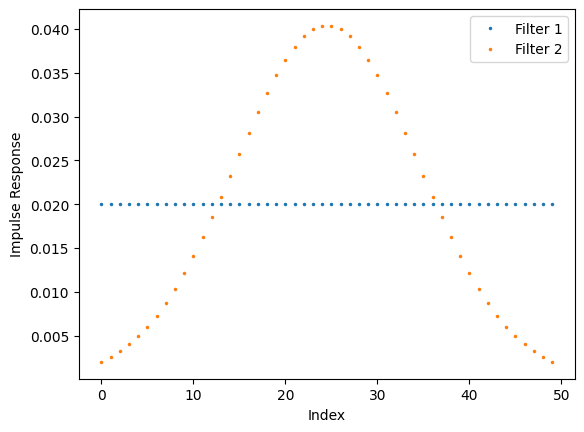

In [32]:
# Visualise the impulse response of the two filters
plt.plot(response.T, ".", markersize=3)

plt.xlabel("Index")
plt.ylabel("Impulse Response")
plt.legend(["Filter 1", "Filter 2"])

Filter 1 returns a constant value of 0.02 from time 0 to 50, whereas filter 2 exhibits an output that increases from 0 to 0.04 between time 0 and 25 and decreases back to 0 until time 50. The impulse responses of the two filters resemble a uniform and a normal distribution, respectively. Both responses equal 0 outside of the time range shown in the figure.

### Section B

The filters are then applied to `dataVec`. The corresponding time sequence is generated for a duration of 1 second sampled at a frequency of 10000 Hz.

In [109]:
# Apply filters to the data
y = apply_filter(dataVec, filtVec)

# Set experimental parameters
Fs = dataVec.size
T = 1

# Generate time sequence
time = 1000 * np.linspace(0, T, T * Fs)

The amplitudes of the raw and filtered signals over time are visualised and compared below.

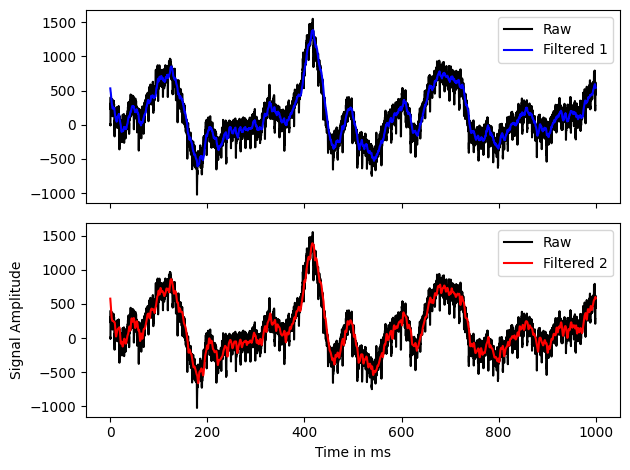

In [110]:
fig, axes = plt.subplots(2, sharex=True)

# Visualise filtered signal 1 and compare with raw
axes[0].plot(time, dataVec, linewidth=1.5, c="k", label="Raw")
axes[0].plot(time, y[0, :], linewidth=1.5, c="b", label="Filtered 1")

# Visualise filtered signal 2 and compare with raw
axes[1].plot(time, dataVec, linewidth=1.5, c="k", label="Raw")
axes[1].plot(time, y[1, :], linewidth=1.5, c="r", label="Filtered 2")

axes[1].set_xlabel("Time in ms")
axes[1].set_ylabel("Signal Amplitude")
axes[1].set_ylabel("Signal Amplitude")

axes[0].legend(loc="upper right")
axes[1].legend(loc="upper right")

plt.tight_layout()

It appears that both filters remove high frequencies and maintain low ones, but they do it at a different degree or at a different threshold, because Filtered 2 shows slightly bigger oscillations than Filtered 1 over the entire time series.

### Section C

The spectra of the raw and the filtered signals are determined via DFT. The frequency range was chosen by considering the Nyquist frequency (5000 Hz) and excluding areas with extremely high power (between 0 and 15 Hz) and without visible difference between the filters (above 1000 Hz).

In [56]:
# Collect frequencies
freq = fftfreq(Fs * T, d=1 / Fs)
# Define frequency limits
x0, xf = 15, 1000

# Perform FFT on raw signal
y0 = fft(dataVec - np.mean(dataVec))
# Perform FFT on filtered signal
yf = fft(y - np.mean(y), axis=1)

The spectra of the filtered signals are overlayed with that of the raw signal and compared.

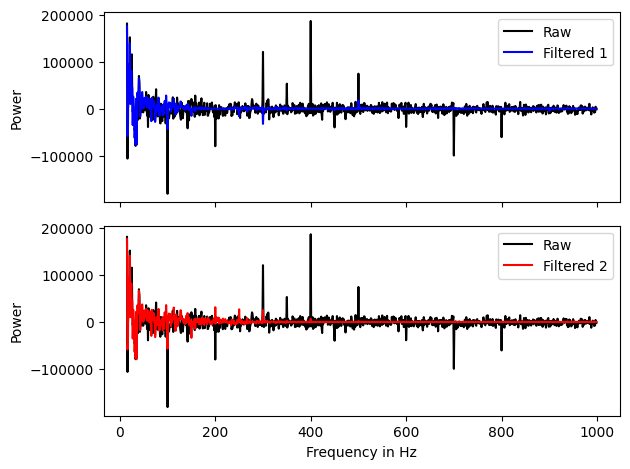

In [57]:
fig, axes = plt.subplots(2, sharex=True)

# Visualise spectrum of filtered signal 1 and compare with raw
axes[0].plot(freq[x0:xf], y0[x0:xf], c="k", label="Raw")
axes[0].plot(freq[x0:xf], yf[0, x0:xf], c="b", label="Filtered 1")

# Visualise spectrum of filtered signal 2 and compare with raw
axes[1].plot(freq[x0:xf], y0[x0:xf], c="k", label="Raw")
axes[1].plot(freq[x0:xf], yf[1, x0:xf], c="r", label="Filtered 2")

axes[1].set_xlabel("Frequency in Hz")
axes[0].set_ylabel("Power")
axes[1].set_ylabel("Power")

axes[0].legend(loc="upper right")
axes[1].legend(loc="upper right")

plt.tight_layout()

Compared to filter 2, filter 1 seems slightly more stringent at lower frequencies between 0 and 200 Hz. The spectrum for filter 1 exhibit very small oscillations that continue for the entire frequency range until 1000 Hz, whereas the spectrum for filter 2 already reaches a plateau at about 400 Hz. This together with the previous results on the impulse responses suggest that filter 1 is IIR and filter 2 is FIR.

### Section D

To give greater insight into the nature of the filters, the power spectral density of the filtered signals is estimated with the Welch method.

In [93]:
# Perform Welch method on raw signal
freq, y0w = welch(dataVec, fs=Fs, noverlap=0, nperseg=2 * Fs)
# Perform Welch method on filtered signal
freq, yfw = welch(y, fs=Fs, noverlap=0, nperseg=2 * Fs)

The power spectral density of the two filtered signals is visualised below and compared to that of the raw signal.

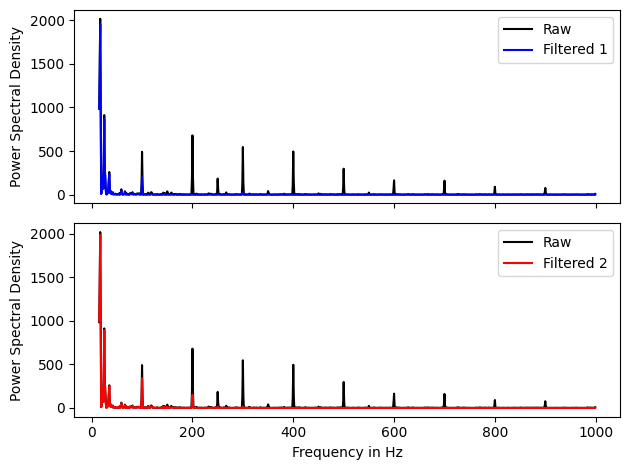

In [113]:
fig, axes = plt.subplots(2, sharex=True)

# Visualise Welch spectrum of filtered signal 1 and compare with raw
axes[0].plot(freq[x0:xf], y0w[x0:xf], c="k", label="Raw")
axes[0].plot(freq[x0:xf], yfw[0, x0:xf], c="b", label="Filtered 1")

# Visualise Welch spectrum of filtered signal 2 and compare with raw
axes[1].plot(freq[x0:xf], y0w[x0:xf], c="k", label="Raw")
axes[1].plot(freq[x0:xf], yfw[1, x0:xf], c="r", label="Filtered 2")

axes[1].set_xlabel("Frequency in Hz")
axes[0].set_ylabel("Power Spectral Density")
axes[1].set_ylabel("Power Spectral Density")

axes[0].legend(loc="upper right")
axes[1].legend(loc="upper right")

plt.tight_layout()

As expected, both filters target higher frequencies. However, filter 1 might have a higher degree or more stringent threshold that affects lower frequencies to a greater extent than filter 2. Taken altogether, we suspect that filter 1 is a lowpass IIR filter of higher order, whereas filter 2 is a lowpass FIR of lower order.

### Section E

As discussed above, both filters remove high frequencies and are therefore lowpass (probably with a threshold around 50 Hz). However, filter 1 might have a higher degree because it decays faster. Instead, an ideal lowpass filter would make perfect discrimination between frequencies below and above the threshold, which would result in the total removal of all frequencies above the threshold, while having no effect at all on those below the threshold. In addition, it would not create any wripples around the threshold.

## Task 4: PSD and Coherence

### Section A and B

The data is imported and the background and neuron signals are stored in two separate objects.

In [3]:
# Import data
coherence = np.load("data/coherence.npy", allow_pickle=True)
fwrsig_nospikes = coherence.item().get("fwrsig_nospikes").flatten()
st = coherence.item().get("st").toarray().flatten()

The Welch method is applied to the signals with a sampling rate of 24038 Hz and no overlap between windows. The window size was set to twice the sampling frequency (48076 Hz) to achieve a frequency resolution of 0.5 Hz.

In [4]:
# Set sampling rate
Fs = 24038

# Perform Welch method on background activity
freq, fwr_power = welch(fwrsig_nospikes, fs=Fs, noverlap=0, nperseg=2 * Fs)
# Perform Welch methon on neuron activity
freq, st_power = welch(st, fs=Fs, noverlap=0, nperseg=2 * Fs)

The spectrum should be plotted from 3 to 70 Hz, whereas normalisation should be based on frequencies between 30 and 70 Hz. Those two frequency ranges are detected and the two signals are normalised.

In [5]:
# Define frequency ranges for plotting and normalising
min_plot_freq, min_norm_freq, max_freq = 3, 30, 70
# Collect indices for normalisation
norm_idx = np.where((freq >= min_norm_freq) & (freq <= max_freq))
# Collect indices for plotting
plot_idx = np.where((freq >= min_plot_freq) & (freq <= max_freq))

# Normalise power of background activity
norm_fwr_power = fwr_power[plot_idx] / np.sum(fwr_power[norm_idx])
# Normalise power of neuron activity
norm_st_power = st_power[plot_idx] / np.sum(st_power[norm_idx])

The threshold to select primary frequencies is defined as $d = \mu_{norm\ 30-70} + 5\sigma_{norm\ 30-70}$, where $\mu$ and $\sigma$ represent the mean and standard deviation of the frequency range between 30 and 70 Hz for a given signal, respectively. The threshold for the two signals is computed below.

In [6]:
# Select range of spectrum for normalisation
threshold_fwr_power = fwr_power[norm_idx] / np.sum(fwr_power[norm_idx])
threshold_st_power = st_power[norm_idx] / np.sum(st_power[norm_idx])

# Find mean and std of range of spectrum for normalisation of background activity
fwr_mean = np.mean(threshold_fwr_power)
fwr_std = np.std(threshold_fwr_power)

# Find mean and std of range of spectrum for normalisation of neuron activity
st_mean = np.mean(threshold_st_power)
st_std = np.std(threshold_st_power)

# Compute threshold power for background activity
fwr_threshold = fwr_mean + 5 * fwr_std
# Compute threshold power for neuron activity
st_threshold = st_mean + 5 * st_std

print(f"Threshold Power for Background Activity: {fwr_threshold:.3g}")
print(f"Threshold Power for Neuron Activity: {st_threshold:.3g}")

Threshold Power for Background Activity: 0.0226
Threshold Power for Neuron Activity: 0.0247


The spectra of the background and neuron activity are visualised along with their respective power thresholds.

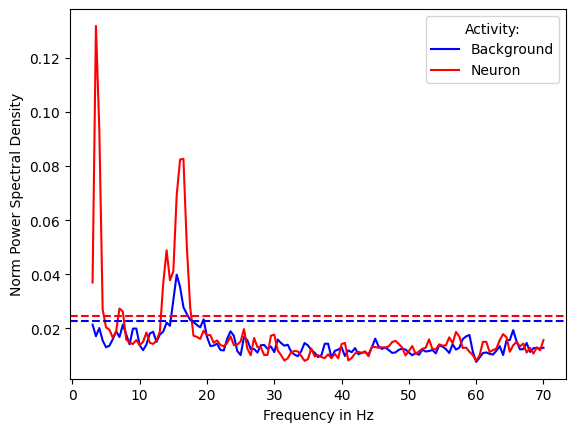

In [7]:
# Visualise spectra
plt.plot(freq[plot_idx], norm_fwr_power, label="Background", c="b")
plt.plot(freq[plot_idx], norm_st_power, label="Neuron", c="r")

# Mark power thresholds
plt.axhline(y=fwr_threshold, linestyle="--", c="b")
plt.axhline(y=st_threshold, linestyle="--", c="r")

plt.xlabel("Frequency in Hz")
plt.ylabel("Norm Power Spectral Density")
plt.legend(title="Activity:")

A short range from 15 to 19.5 Hz passes the threshold for the background activity, whereas three separate ranges (from 3 to 4.5, from 7 to 7.5 and from 14 to 17 Hz) pass the threshold for the neuron activity.

In [17]:
# Find frequencies above threshold for background activity
fwr_keep = freq[plot_idx][norm_fwr_power > fwr_threshold]
# Find frequencies above threshold for neuron activity
st_keep = freq[plot_idx][norm_st_power > st_threshold]

print("Principal Oscillation Frequencies (Hz):")
print(f"fwr: {fwr_keep}")
print(f"st: {st_keep}")

Principal Oscillation Frequencies (Hz):
fwr: [15.  15.5 16.  16.5 17.  17.5 19.5]
st: [ 3.   3.5  4.   4.5  7.   7.5 13.5 14.  14.5 15.  15.5 16.  16.5 17.
 17.5]


### Section C

The cross-spectrum between the two signals is computed with the same parameters used for Welch method.

In [56]:
# Compute cross-spectrum between background and neuron
freq, cross_spectrum = csd(fwrsig_nospikes, st, Fs, noverlap=0, nperseg=2 * Fs)
# Select range of cross-spectrum for visualisation
cross_spectrum = cross_spectrum[plot_idx]

The resulting cross-spectrum is visualised below for the frequency range of interest.

Text(0, 0.5, 'Cross Spectral Density')

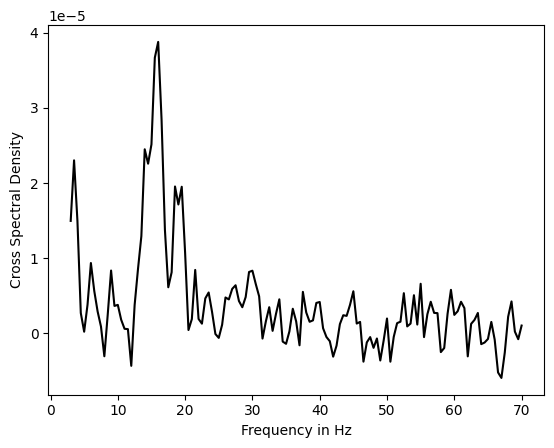

In [19]:
# Visualise cross-spectrum
plt.plot(freq[plot_idx], cross_spectrum, label="Background", c="k")

plt.xlabel("Frequency in Hz")
plt.ylabel("Cross Spectral Density")

Based on the cross-spectrum, the two signals show an increased association at a frequency of 3.5 Hz and between 14 and 16.5 Hz. However, this will be further assessed by measuring coherence.

### Section D

Coherence does not depend on amplitude and phase of the components of the two signals. Thus, it provides an unbiased estimate of their correlation in the frequency domain. Coherence is derived below from the cross-spectrum with the following definition:

$C_{xy}(f) = \frac{\mid G_{xy}(f)\mid^2}{G_{xx}(f)G_{yy}(f)}$

where $G_{ii}(f)$ is the auto-spectrum of $i$ and $G_{ij}(f)$ is the cross-spectrum between $i$ and $j$.

In [57]:
# Compute coherence from cross-spectrum
coherence = np.abs(cross_spectrum)**2 / (fwr_power[plot_idx] * st_power[plot_idx])

The coherence between the two signals is visualised below.

Text(0, 0.5, 'Coherence')

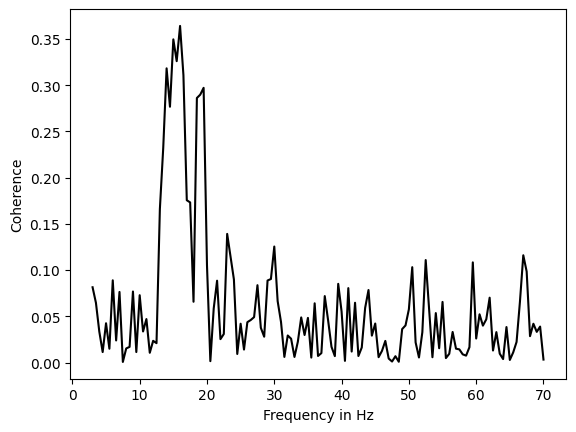

In [58]:
# Visualise coherence
plt.plot(freq[plot_idx], coherence, c="k")

plt.xlabel("Frequency in Hz")
plt.ylabel("Coherence")

The coherence plot suggests that the background and neuron activity might be linked at frequencies between 13.5 and 19.5 Hz. Information about the phases related to such frequencies can be extracted from the previously calculated cross-spectrum.

In [69]:
# Set coherence threshold
coherence_threshold = 0.2

# Select frequencies with a high coherence
selected_freq = freq[plot_idx][coherence > coherence_threshold]

# Find phases of selected frequencies from cross-spectrum
selected_phase = np.angle(cross_spectrum[coherence > coherence_threshold], deg=True)

The primary frequencies that link the two signals and their corresponding phases are visualised below.

Text(0, 0.5, 'Phase in deg')

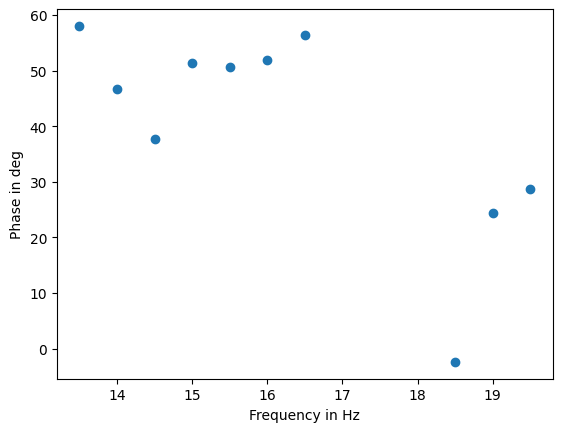

In [70]:
# Visualise selected frequencies and their phases
plt.scatter(selected_freq, selected_phase)

plt.xlabel("Frequency in Hz")
plt.ylabel("Phase in deg")

There seem to be two clouds of frequencies with similar phases. The first spans from 13.5 to 17.5 Hz and exhibits a mean phase of 50°. The second includes 19 and 19.5 Hz and exhibits a mean phase of 26°. These two groups of frequencies might represent the components that the two signals share and their respective defferences in phase.

### Section E

Here, phase locking is used to investigate whether certain phases of the background activity are linked to spikes in the neuron activity. To obtain information on the phases, the Hilbert transform can be applied. However, this transformation requires a tidy signal. Thus, the signals are first processed with filters to select the primary frequencies identified in section B.

The frequencies of interest in the background activity range between 15 adnd 19.5 Hz. They can be selected with a Butterworth bandpass filter.

In [ ]:
# Design Butterworth filter for background activity
b, a = butter(2, [fwr_keep[0], fwr_keep[-1]], btype="band", fs=Fs)

# Apply filter to background activity
filtered_fwr = lfilter(b, a, fwrsig_nospikes)

# Perform Welch method on filtered background activity
freq, filtered_fwr_power = welch(filtered_fwr, fs=Fs, noverlap=0, nperseg=2 * Fs)

The spectrum of the filtered background activity is visualised below. The frequencies of interest are selected relatively well and lie within the band of the filter.

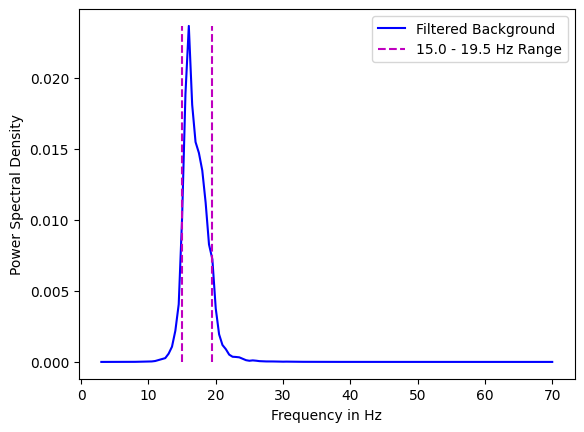

In [47]:
# Visualise spectrum of filtered background activity
plt.plot(freq[plot_idx], filtered_fwr_power[plot_idx], c="b", label="Filtered Background")

# Marker selected frequency ranges
plt.vlines(
    [fwr_keep[0], fwr_keep[-1]], ymin=0, ymax=max(filtered_fwr_power),
    color="m", linestyle="--", label=f"{fwr_keep[0]} - {fwr_keep[-1]} Hz Range"
)

plt.xlabel("Frequency in Hz")
plt.ylabel("Power Spectral Density")
plt.legend()

The frequencies of interest in the neuron activity belong to two separate ranges (from 3 to 7.5 Hz and from 13.5 to 17.5 Hz). Therefore, first a bandpass filter is applied to select an area containing both ranges, and then a bandstop filter is used to remove the region between the two ranges of interest.

In [ ]:
# Design bandpass filter to select frequencies between 3 and 17.5 Hz
b1, a1 = butter(2, [st_keep[0], st_keep[-1]], fs=Fs, btype="band")
# Design bandstop filter to remove frequencies between 7.5 and 13.5 Hz
b2, a2 = butter(2, [st_keep[5], st_keep[6]], fs=Fs, btype="stop")

# Apply banpass filter to neuron activity
filtered_st = lfilter(b1, a1, st)
# Apply bandstop filter to neuron activity
filtered_st = lfilter(b2, a2, filtered_st)

# Perform Welch method on filtered neuron activity
freq, filtered_st_power = welch(filtered_st, fs=Fs, noverlap=0, nperseg=2 * Fs)

The spectrum of the filtered neuron activity is visualised below. The two frequency ranges are successfully retained.

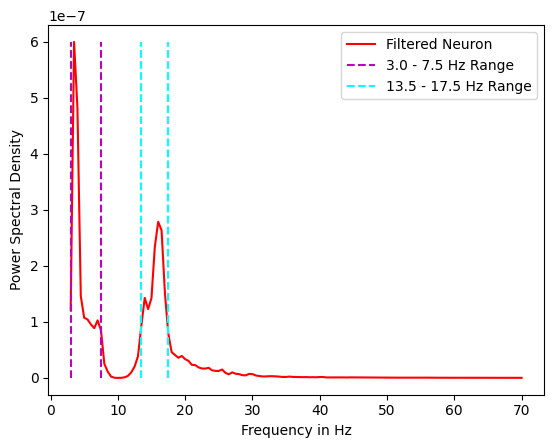

In [44]:
# Visualise spectrum of filtered neuron activity
plt.plot(freq[plot_idx], filtered_st_power[plot_idx], c="r", label="Filtered Neuron")

# Mark selected frequency ranges
plt.vlines(
    [st_keep[0], st_keep[5]], ymin=0, ymax=max(filtered_st_power),
    color="m", linestyle="--", label=f"{st_keep[0]} - {st_keep[5]} Hz Range"
)

# Mark selected frequency ranges
plt.vlines(
    [st_keep[6], st_keep[-1]], ymin=0, ymax=max(filtered_st_power),
    color="cyan", linestyle="--", label=f"{st_keep[6]} - {st_keep[-1]} Hz Range"
)

plt.xlabel("Frequency in Hz")
plt.ylabel("Power Spectral Density")
plt.legend()

The analytic signal is obtained from the Hilbert transform of the filtered background activity. Only elements that correspond to a spike in the neuron activity are selected. The phases of such elements can then be extracted from the analytic signal to find the circular mean phase.

In [45]:
# Perform Hilbert transform on filtered background activity
analytic_fwr = hilbert(filtered_fwr)
# Select elements of analytic background activity that correspond to spikes
spike_background = analytic_fwr[st == 1]

# Find amplitude envelope of analytic background activity
amplitude_envelope = np.abs(spike_background)
# Find phases of analytic background activity
phase = np.angle(spike_background)

# Compute angular mean of the phases
phase_mean = np.rad2deg(circmean(phase, low=phase.min(), high=phase.max()))

print(f"Most exciting phase computed by circular mean: {phase_mean:.3g}°")

Most exciting phase computed by circular mean: -17.7°


A circular mean phase of -17.7° or 342.3° was found. The distribution of the background phases related to spikes is visualised below with a polar barplot.

Text(0.5, 1.0, 'Phase of Background Activity upon Spike')

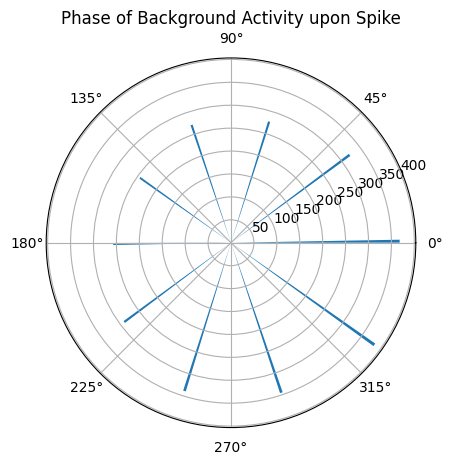

In [46]:
# Initialise polar barplot
ax = plt.subplot(polar=True)

# Visualise background phases related to spikes
ax.hist(phase, width=np.deg2rad(1))

ax.set_title("Phase of Background Activity upon Spike")

The background phases related to spikes appear at intervals of 36° in the polar barplot. The most frequent phase corresponds to 324°. This suggests that spikes might preferably occur with a phase difference of 36° from certain oscillations in the background activity.

### Section F

Coherence and Phase-Locking Value (PLV) via Hilbert transform represent two different approaches to study the associations in oscillatory behaviour between signals. While coherence measures interactions as a function of frequency, PLV defines it in terms of relative phases between signals (Aydore et al, 2013). Even though it is possible to integrate coherence with information on phase obtained from a cross-spectrum, PLV can be regarded as a more straightforward method to investigate such question. Compared to PLS, coherence is a more established method, is less computationally demanding, and produces easily interpretable results. However, PLS imposes less strict assumptions on the stationarity and linearity of a signal and therefore provides more robust results for neural data that is often non-stationary (Lowet et al, 2016). There have been efforts to compare and converge results from these two approaches, which seem strongest when combined (Lepage et al., 2017). Therefore, both approaches can be recommended and function especially well when used to complement each other.

## References

1. Aydore, Sergul, Dimitrios Pantazis, and Richard M. Leahy. "A note on the phase locking value and its properties." Neuroimage 74 (2013): 231-244.
2. Ayzenshtat, Inbal, et al. "Precise spatiotemporal patterns among visual cortical areas and their relation to visual stimulus processing." Journal of Neuroscience 30.33 (2010): 11232-11245.
3. Lepage, Kyle Q., and Sujith Vijayan. "The relationship between coherence and the phase-locking value." Journal of Theoretical Biology 435 (2017): 106-109.
4. Lowet, Eric, et al. "Quantifying neural oscillatory synchronization: a comparison between spectral coherence and phase-locking value approaches." PloS one 11.1 (2016): e0146443.
5. Shoham, Doron, et al. "Imaging cortical dynamics at high spatial and temporal resolution with novel blue voltage-sensitive dyes." Neuron 24.4 (1999): 791-802.